#**Install necessary libraries**

In [1]:
!pip install tensorflow yfinance pandas numpy matplotlib seaborn scikit-learn


#**Import libraries**

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math

#**Fetch data**


In [3]:
ticker = "AAPL"
data = yf.download(ticker, start="2010-01-01", end="2023-01-01")

[*********************100%%**********************]  1 of 1 completed


#**Check for missing values and drop if any**

In [4]:
data.dropna(inplace=True)
data.reset_index(inplace=True)

#**Visualize the stock prices**

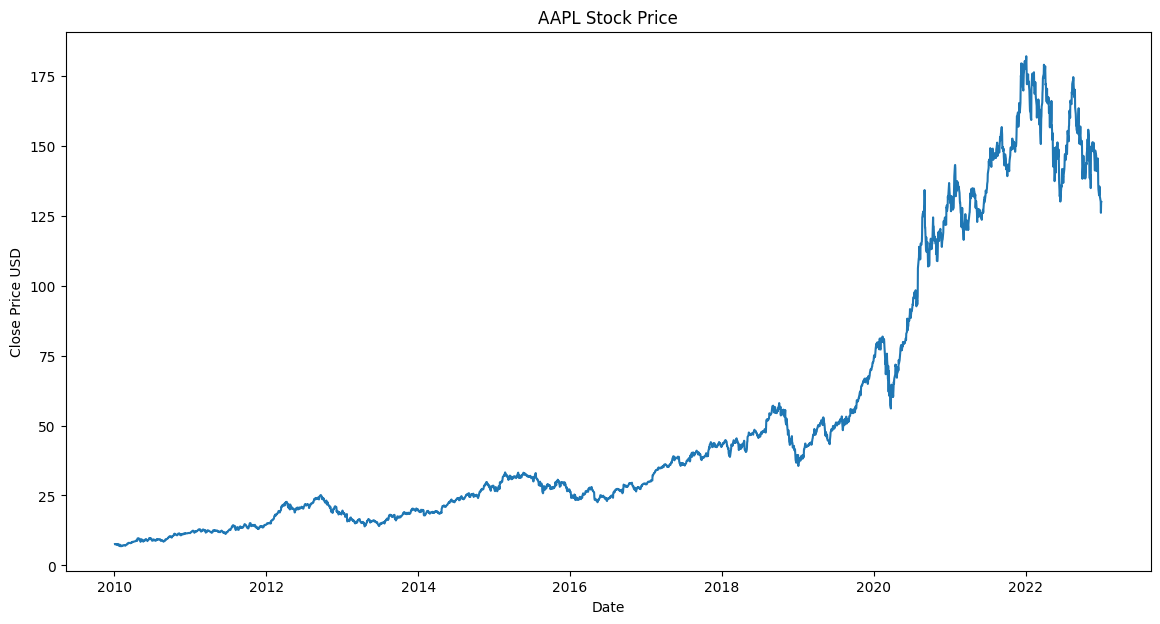

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'])
plt.title(f"{ticker} Stock Price")
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.show()


#**Feature Engineering**

In [6]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek

#**Data Normalization**

In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close']])

#**Create the dataset for LSTM**


In [8]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

#**Reshape the input to be [samples, time steps, features] for LSTM**


In [9]:
X = X.reshape(X.shape[0], X.shape[1], 1)


#**Split the data into training and testing sets**


In [10]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

#**Build the LSTM model**


In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#**Compile the model**

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

#**Train the model**


In [13]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

2536/2536 [==============================] - 134s 52ms/step - loss: 2.8213e-04


#**Make predictions**


In [14]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


20/20 [==============================] - 2s 33ms/step


#**Calculate evaluation metrics**


In [18]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def adjusted_r_squared(y_true, y_pred, n, p):
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    return adjusted_r2

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = adjusted_r_squared(y_test, y_pred, len(y_test), X_test.shape[1])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R²): {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

Mean Absolute Error (MAE): 5.338978023979608
Mean Squared Error (MSE): 43.94441886368605
Root Mean Squared Error (RMSE): 6.629058671009486
Mean Absolute Percentage Error (MAPE): 3.8056073115270728
R-squared (R²): 0.8929582780072688
Adjusted R-squared: 0.8729130117164952


#**Visualize the predictions**


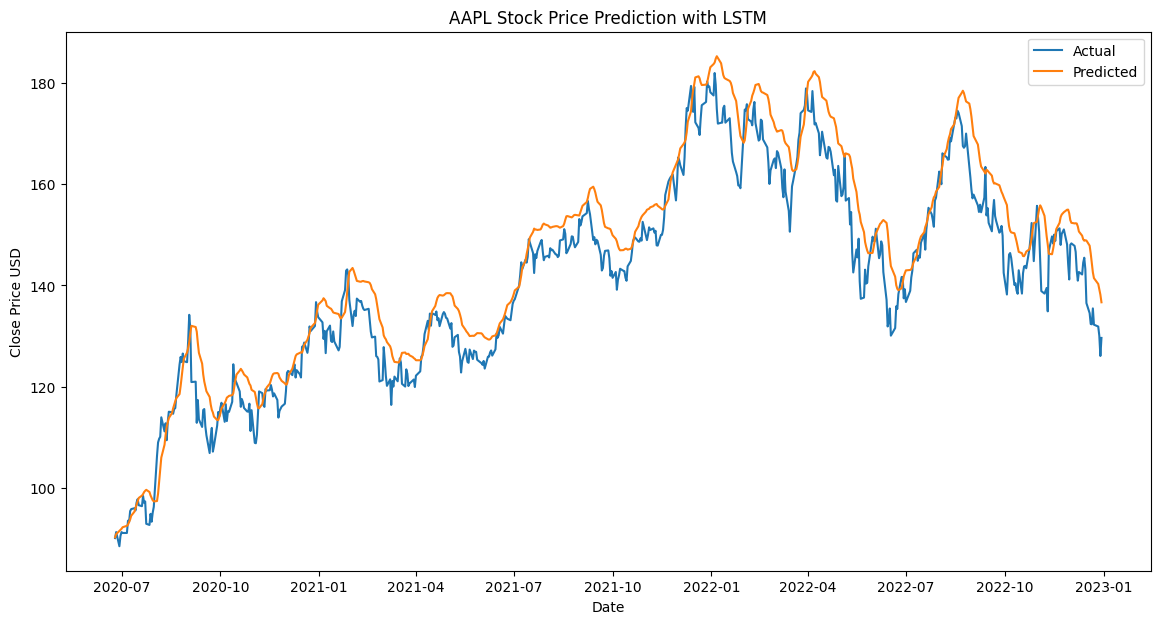

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(data['Date'][len(data)-len(y_test):], y_test, label='Actual')
plt.plot(data['Date'][len(data)-len(y_test):], y_pred, label='Predicted')
plt.title(f"{ticker} Stock Price Prediction with LSTM")
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.legend()
plt.show()